In [3]:
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
from model import Generator
from checkpoint import load_checkpoint
from utils import get_config, resolve_path

Loading configuration...
Using device: cuda
Initializing the generator...
Resolving checkpoint path...
Loading checkpoint from: /arc/home/Amirabezine/deepSpectra/checkpoints//checkpoint_best.pth.tar
Loading checkpoint '/arc/home/Amirabezine/deepSpectra/checkpoints//checkpoint_best.pth.tar'
Best model loaded successfully.
Generator set to evaluation mode.
Generating random latent code...
Latent code generated.
Generating spectrum...
Spectrum generated.
Opening HDF5 file...
Data loaded from HDF5 file.
Plotting the generated spectrum...


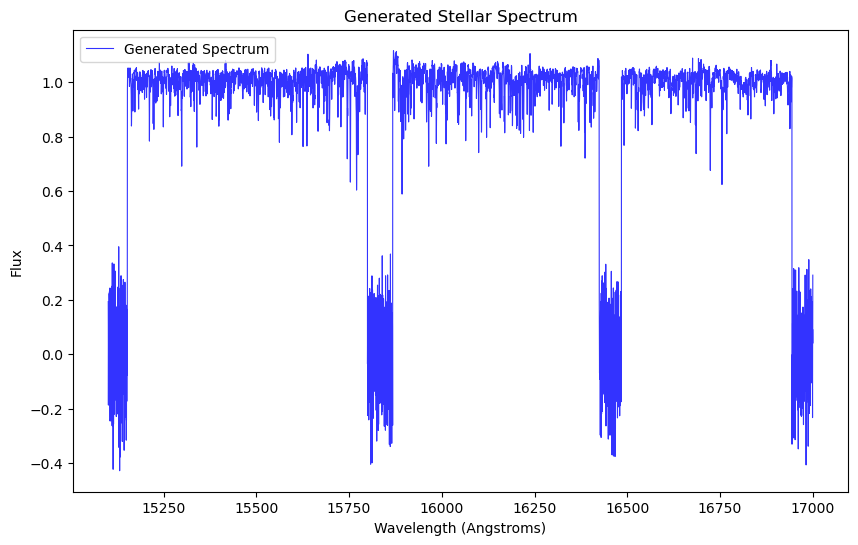

Plotting the spectra comparison...


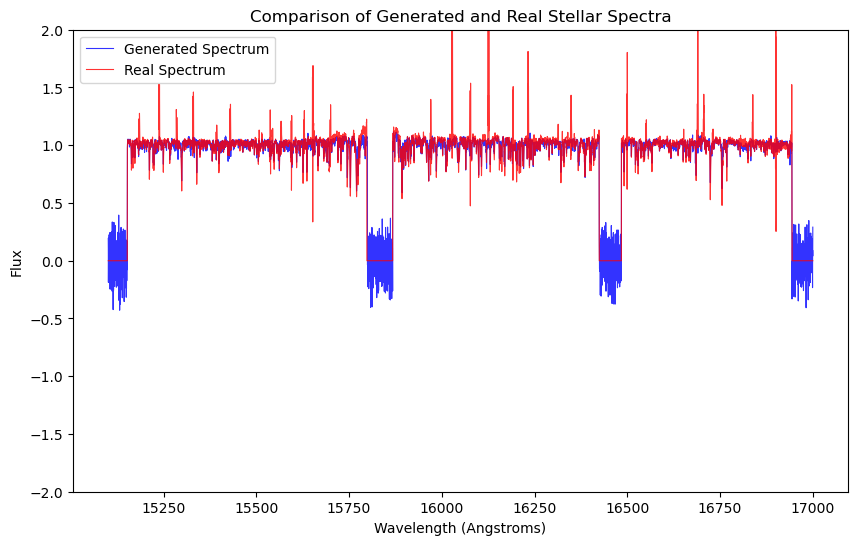

Plotting completed.


In [4]:
def generate_and_plot_spectrum():
    print("Loading configuration...")
    config = get_config()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize generator
    latent_dim = config['training']['latent_dim']
    output_dim = config['model']['output_dim']
    generator_layers = config['model']['generator_layers']
    activation_function = getattr(torch.nn, config['model']['activation_function'])
    
    print("Initializing the generator...")
    generator = Generator(latent_dim, output_dim, generator_layers, activation_function).to(device)

    # Load best model checkpoint
    print("Resolving checkpoint path...")
    best_checkpoint_path = resolve_path(config['paths']['checkpoints']) + '/checkpoint_best.pth.tar'
    print(f"Loading checkpoint from: {best_checkpoint_path}")
    best_checkpoint = load_checkpoint(best_checkpoint_path)
    
    if best_checkpoint:
        generator.load_state_dict(best_checkpoint['state_dict'])
        print("Best model loaded successfully.")
    else:
        print("Error loading the best model.")
        return

    generator.eval()
    print("Generator set to evaluation mode.")

    # Generate a random latent code
    print("Generating random latent code...")
    latent_code = torch.randn(1, latent_dim, device=device)
    print("Latent code generated.")

    # Generate spectrum
    print("Generating spectrum...")
    with torch.no_grad():
        generated_flux = generator(latent_code).squeeze().cpu().numpy()
    print("Spectrum generated.")

    # Load an example spectrum from HDF5
    print("Opening HDF5 file...")
    hdf5_file = resolve_path(config['paths']['hdf5_data'])
    with h5py.File(hdf5_file, 'r') as file:
        keys = list(file.keys())
        data = file[keys[0]]  # Load the first spectrum
        real_flux = data['flux'][:]
        wavelength = data['wavelength'][:]  # Use the same wavelength for generated spectrum for consistency

    print("Data loaded from HDF5 file.")

    # Plot the generated spectrum only
    print("Plotting the generated spectrum...")
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, generated_flux, label='Generated Spectrum', color='blue', alpha=0.8, linewidth=0.8)
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux')
    plt.title('Generated Stellar Spectrum')
    plt.legend()
    plt.savefig("generated_spectrum.png")
    plt.show()
    
    # Plot the generated and real spectra together
    print("Plotting the spectra comparison...")
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, generated_flux, label='Generated Spectrum', color='blue', alpha=0.8, linewidth=0.8)
    plt.plot(wavelength, real_flux, label='Real Spectrum', color='red', alpha=0.8, linewidth=0.8)
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux')
    plt.ylim(-2,2)
    plt.title('Comparison of Generated and Real Stellar Spectra')
    plt.legend()
    plt.savefig("comparison.png")
    plt.show()
    print("Plotting completed.")

if __name__ == "__main__":
    generate_and_plot_spectrum()
